In [1]:
import numpy as np
import copy

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib

import torch
import torch.nn as nn
import torch.nn.functional as F
import dtnnlib as dtnn

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (9, 8)

In [2]:
# device = torch.device("cuda:0")
device = torch.device("cpu")

## On 2D dataset

In [3]:
## Set 1
num_points = 50
X1 = np.linspace(-2.5, 1.5, num_points)
X2 = np.linspace(-2, 4, num_points)
X1, X2 = np.meshgrid(X1, X2)
Y = np.sin(np.sqrt(X1**2 + X2**2))*2-1.

/home/tsuman/Program_Files/Python/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  # This is added back by InteractiveShellApp.init_path()


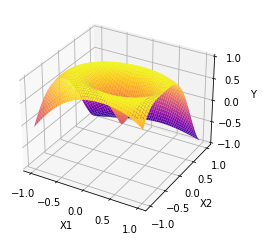

In [4]:
####Scaling the data to range -1,1
X1 = 2*(X1 - X1.min())/(X1.max() - X1.min()) -1
X2 = 2*(X2 - X2.min())/(X2.max() - X2.min()) -1
Y = 2*(Y - Y.min())/(Y.max() - Y.min()) -1

x1 = X1.reshape(-1)
x2 = X2.reshape(-1)

%matplotlib inline
fig = plt.figure()
ax = fig.gca(projection='3d')
# ax.scatter(X1, X2, Y)
ax.plot_surface(X1, X2, Y, cmap='plasma')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')
plt.show()

In [5]:
xx = torch.Tensor(np.c_[x1, x2])
yy = torch.Tensor(Y.reshape(-1,1))

## Building 2D model

In [148]:
class DistanceTransform_Epsilon(dtnn.DistanceTransformBase):
    
    def __init__(self, input_dim, num_centers, p=2, bias=False, epsilon=0.1):
        super().__init__(input_dim, num_centers, p=2)
        
        nc = num_centers
        if epsilon is not None:
            nc += 1
        self.scaler = nn.Parameter(torch.log(torch.ones(1, 1)*1))
        self.bias = nn.Parameter(torch.ones(1, nc)*0) if bias else None
        self.epsilon = epsilon
        
    def forward(self, x):
        dists = super().forward(x)
        
        if self.epsilon is not None:
            dists = torch.cat([dists, torch.ones(len(x), 1, dtype=x.dtype)*self.epsilon], dim=1)
        
        ### normalize similar to UMAP
        dists = dists/torch.sqrt(dists.var(dim=1, keepdim=True)+1e-9)
        
        ## scale the dists
#         dists = torch.exp(-dists + self.scaler)
        dists = 1-dists*torch.exp(self.scaler)
    
        if self.bias is not None: dists = dists+self.bias
        return dists
    
class DTeSM(DistanceTransform_Epsilon):
    
    def __init__(self, input_dim, output_dim, epsilon=1.0):
        super().__init__(input_dim, output_dim, bias=True, epsilon=epsilon)
        
        self.scale_shift = dtnn.ScaleShift(-1, scaler_init=10, shifter_init=0, scaler_const=True, shifter_const=True)
        self.softmax = nn.Softmax(dim=-1)
        self.temp_activ = None
        
    def forward(self, x):
        xo = super().forward(x)
        xo = self.scale_shift(xo)
        xo = self.softmax(xo)
        self.temp_activ = xo.data
#         return xo[:, :-1]
        return xo

In [149]:
class LocalMLP_epsilonsoftmax_3L(nn.Module):
    
    def __init__(self, input_dim, hidden_dim0, hidden_dim1, output_dim, epsilon=1.0):
        super().__init__()
        
        self.layer0 = DTeSM(input_dim, hidden_dim0, epsilon=epsilon)
                
        if epsilon is not None:
            hidden_dim0 += 1

        self.layer1 = DTeSM(hidden_dim0, hidden_dim1, epsilon=epsilon)
        
        if epsilon is not None:
            hidden_dim1 += 1
        
#         self.activ = dtnn.OneActiv(hdim, mode='relu', beta_init=np.log(1.2))
#         self.activ = nn.ReLU()

        self.layer2 = nn.Linear(hidden_dim1, output_dim)
        pass
        
    def forward(self, x):
        xo = self.layer0(x)
        xo = self.layer1(xo)
        xo = self.layer2(xo)
        return xo

In [8]:
model = LocalMLP_epsilonsoftmax_3L(2, 5, 5, 1, epsilon=1.0).to(device)

In [9]:
model

LocalMLP_epsilonsoftmax_3L(
  (layer0): DTeSM(
    (scale_shift): ScaleShift()
    (softmax): Softmax(dim=-1)
  )
  (layer1): DTeSM(
    (scale_shift): ScaleShift()
    (softmax): Softmax(dim=-1)
  )
  (layer2): Linear(in_features=6, out_features=1, bias=True)
)

In [10]:
yout = model.forward(xx)
xx.shape, yout.shape

(torch.Size([2500, 2]), torch.Size([2500, 1]))

In [11]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0031)
criterion = nn.MSELoss()

/home/tsuman/Program_Files/Python/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  This is separate from the ipykernel package so we can avoid doing imports until


0 Error =  0.9321115016937256
200 Error =  0.04383067041635513
400 Error =  0.025032689794898033
600 Error =  0.02192021906375885
800 Error =  0.020270852372050285
1000 Error =  0.01902337558567524
1200 Error =  0.0181207787245512
1400 Error =  0.017233559861779213
1600 Error =  0.016830187290906906
1800 Error =  0.01661180518567562
2000 Error =  0.016493842005729675
2200 Error =  0.01632283255457878
2400 Error =  0.01614442840218544
2600 Error =  0.015947546809911728
2800 Error =  0.008668539114296436
3000 Error =  0.0030578032601624727
3200 Error =  0.0020451191812753677
3400 Error =  0.0015945035265758634
3600 Error =  0.0014150472125038505
3800 Error =  0.001324158743955195
4000 Error =  0.001341971568763256
4200 Error =  0.0012144714128226042
4400 Error =  0.0011724639916792512
4600 Error =  0.0011172249214723706
4800 Error =  0.0010848818346858025


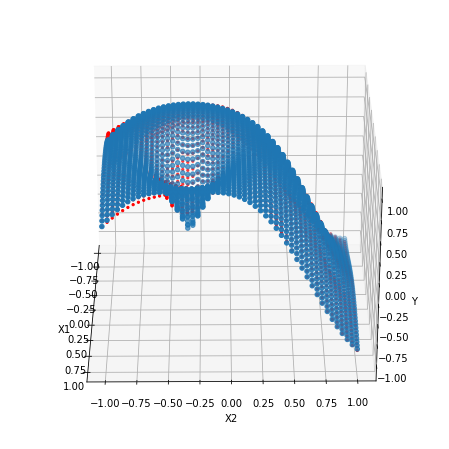

In [12]:
%matplotlib tk
fig = plt.figure(figsize=(9,8))
ax = fig.gca(projection='3d')

for epoch in range(5000):

    yout = model(xx)
    loss = criterion(yout, yy)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch+1)%1000 == 0 or epoch == 0:
        print(epoch, 'Error = ', float(loss))
        ax.clear()
        
        ax.scatter(X1, X2, Y)
        ax.scatter(X1, X2, yout.data.reshape(Y.shape), color='r', marker='.')
        ax.set_xlabel('X1')
        ax.set_ylabel('X2')
        ax.set_zlabel('Y')
        
        fig.canvas.draw()
        plt.pause(0.01)

In [13]:
yout.shape, Y.shape

(torch.Size([2500, 1]), (50, 50))

/home/tsuman/Program_Files/Python/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  This is separate from the ipykernel package so we can avoid doing imports until


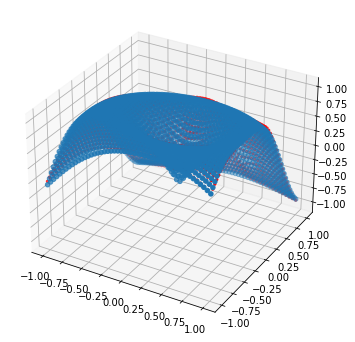

In [14]:
%matplotlib inline
fig = plt.figure(figsize=(8,6))
ax = fig.gca(projection='3d')
ax.scatter(X1, X2, Y)
ax.scatter(X1, X2, yout.data.reshape(-1), color='r', marker='.')
plt.show()

## 1. Classification

In [15]:
def twospirals(n_points, noise=.5, angle=784):
    """
     Returns the two spirals dataset.
    """
    n = np.sqrt(np.random.rand(n_points,1)) * angle * (2*np.pi)/360
    d1x = -np.cos(n)*n + np.random.rand(n_points,1) * noise
    d1y = np.sin(n)*n + np.random.rand(n_points,1) * noise
    return (np.vstack((np.hstack((d1x,d1y)),np.hstack((-d1x,-d1y)))), 
            np.hstack((np.zeros(n_points),np.ones(n_points))))

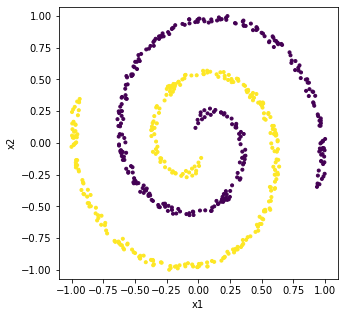

In [16]:
x, y = twospirals(300, angle=560)
x, y = x/x.max(axis=0, keepdims=True), y.reshape(-1)
xx, yy = torch.FloatTensor(x), torch.FloatTensor(y.reshape(-1,1))

x1 = xx[:,0]
x2 = xx[:,1]

%matplotlib inline
plt.figure(figsize=(5,5))
plt.scatter(x1, x2, c=y, marker='.')
# plt.savefig("./clf_toy_data.pdf")
plt.xlabel("x1")
plt.ylabel("x2")
plt.axis("equal")
plt.show()

In [17]:
xx, yy = xx.to(device), yy.to(device)

In [18]:
H0 = 5
H1 = 5
model = LocalMLP_epsilonsoftmax_3L(2, H0, H1, 1, epsilon=1.0)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()

Epoch: 99, Acc:0.57, Loss:0.6734799742698669
Epoch: 199, Acc:0.72, Loss:0.6301552057266235
Epoch: 299, Acc:0.75, Loss:0.5909356474876404
Epoch: 399, Acc:0.77, Loss:0.5640843510627747
Epoch: 499, Acc:0.77, Loss:0.5507194399833679
Epoch: 599, Acc:0.78, Loss:0.5337952971458435
Epoch: 699, Acc:0.79, Loss:0.5125219821929932
Epoch: 799, Acc:0.85, Loss:0.44356444478034973
Epoch: 899, Acc:0.91, Loss:0.3644990921020508
Epoch: 999, Acc:0.97, Loss:0.2749602198600769


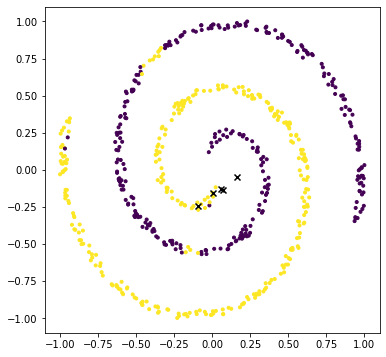

Epoch: 1099, Acc:0.99, Loss:0.2324794977903366
Epoch: 1199, Acc:0.99, Loss:0.20061920583248138
Epoch: 1299, Acc:1.00, Loss:0.17795220017433167
Epoch: 1399, Acc:1.00, Loss:0.1585017293691635
Epoch: 1499, Acc:1.00, Loss:0.14470569789409637
Epoch: 1599, Acc:1.00, Loss:0.13339601457118988
Epoch: 1699, Acc:1.00, Loss:0.12013617157936096
Epoch: 1799, Acc:1.00, Loss:0.11141633242368698
Epoch: 1899, Acc:1.00, Loss:0.10367025434970856
Epoch: 1999, Acc:1.00, Loss:0.09672403335571289


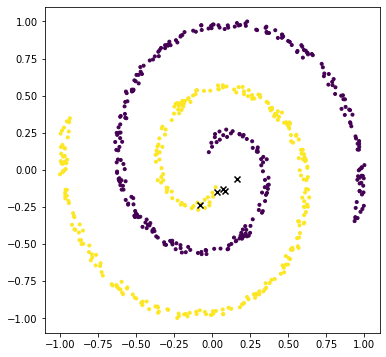

Epoch: 2099, Acc:1.00, Loss:0.09045238792896271
Epoch: 2199, Acc:1.00, Loss:0.08475833386182785
Epoch: 2299, Acc:1.00, Loss:0.07956420630216599
Epoch: 2399, Acc:1.00, Loss:0.07480703294277191
Epoch: 2499, Acc:1.00, Loss:0.07043459266424179
Epoch: 2599, Acc:1.00, Loss:0.06640323251485825
Epoch: 2699, Acc:1.00, Loss:0.06267597526311874
Epoch: 2799, Acc:1.00, Loss:0.05922113358974457
Epoch: 2899, Acc:1.00, Loss:0.05601149797439575
Epoch: 2999, Acc:1.00, Loss:0.053023505955934525


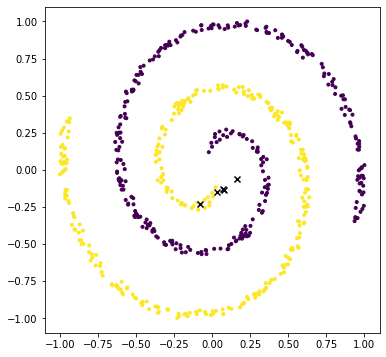

Epoch: 3099, Acc:1.00, Loss:0.050236523151397705
Epoch: 3199, Acc:1.00, Loss:0.04763248562812805
Epoch: 3299, Acc:1.00, Loss:0.045187536627054214
Epoch: 3399, Acc:1.00, Loss:0.0429033488035202
Epoch: 3499, Acc:1.00, Loss:0.04076012596487999
Epoch: 3599, Acc:1.00, Loss:0.03874608129262924
Epoch: 3699, Acc:1.00, Loss:0.036851152777671814
Epoch: 3799, Acc:1.00, Loss:0.03506624698638916
Epoch: 3899, Acc:1.00, Loss:0.03338327258825302
Epoch: 3999, Acc:1.00, Loss:0.031794872134923935


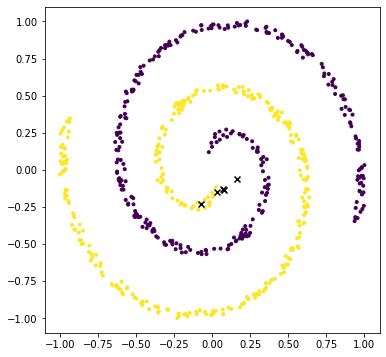

Epoch: 4099, Acc:1.00, Loss:0.03029431588947773
Epoch: 4199, Acc:1.00, Loss:0.028875572606921196
Epoch: 4299, Acc:1.00, Loss:0.027533113956451416
Epoch: 4399, Acc:1.00, Loss:0.026261869817972183
Epoch: 4499, Acc:1.00, Loss:0.025057217106223106
Epoch: 4599, Acc:1.00, Loss:0.02391490526497364
Epoch: 4699, Acc:1.00, Loss:0.022831033915281296
Epoch: 4799, Acc:1.00, Loss:0.021802019327878952
Epoch: 4899, Acc:1.00, Loss:0.020824510604143143
Epoch: 4999, Acc:1.00, Loss:0.01989547722041607


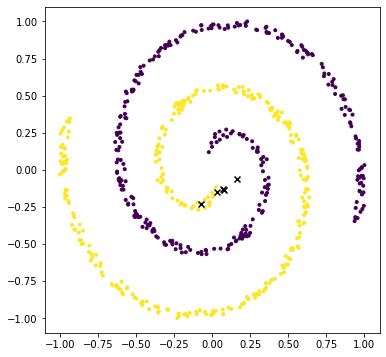

In [19]:
for epoch in range(5000):
    yout = torch.sigmoid(model(xx))
    loss = criterion(yout, yy)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1)%100 == 0:
        accuracy = ((yout>0.5).type(torch.float32) == yy).type(torch.float).mean()                
        print(f'Epoch: {epoch}, Acc:{float(accuracy):.2f}, Loss:{float(loss)}')

    if (epoch+1)%1000 == 0:
        ax = plt.figure(figsize=(6,6)).add_subplot()
        out = (yout.data.cpu().numpy()>0.5).astype(int)
        ax.scatter(x1, x2, c=out, marker= '.')
        ## plot centroids
        c = model.layer0.centers.data.cpu()
        ax.scatter(c[:,0], c[:,1], color='k', marker= 'x')
        plt.show()

### Visualize the distance distribution 

In [35]:
### Layer 0
# a0 = model.layer0.temp_activ.t()[0:]

### Layer 1
a0 = model.layer1.temp_activ.t()[2:]


a0 = a0[:3]

a0.shape

torch.Size([3, 600])

In [36]:
%matplotlib tk
fig = plt.figure(figsize=(9,8))
ax = fig.gca(projection='3d')
ax.scatter(a0[0], a0[1], a0[2], c=yy, alpha=0.5)
# ax.scatter(X1, X2, yout.data.reshape(-1), color='r', marker='.')
ax.set_xlabel('X0')
ax.set_ylabel('X1')
ax.set_zlabel('X2')
plt.show()
plt.pause(5)
plt.close()

/home/tsuman/Program_Files/Python/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  This is separate from the ipykernel package so we can avoid doing imports until


In [22]:
"""
The distances do not seem seperable in layer0, but are seperable in layer1..
"""
print()

## Distance Based Classification - development

In [704]:
class DistanceTransform_Epsilon(dtnn.DistanceTransformBase):
    
    def __init__(self, input_dim, num_centers, p=2, bias=False, epsilon=0.1):
        super().__init__(input_dim, num_centers, p=2)
        
        nc = num_centers
        if epsilon is not None:
            nc += 1
#         self.scaler = nn.Parameter(torch.log(torch.ones(1, 1)*1))
        self.scaler = nn.Parameter(torch.ones(1, 1)*1)

        self.bias = nn.Parameter(torch.ones(1, nc)*0) if bias else None
        self.epsilon = epsilon
        
    def forward(self, x):
        dists = super().forward(x)
        
        if self.epsilon is not None:
            dists = torch.cat([dists, torch.ones(len(x), 1, dtype=x.dtype)*self.epsilon], dim=1)
        
        ### normalize similar to UMAP
#         dists = dists/torch.sqrt(dists.var(dim=1, keepdim=True)+1e-9)
        
        ## scale the dists
#         dists = torch.exp(-dists + self.scaler)
#         dists = 1-dists*torch.exp(self.scaler)
        dists = 1-dists*self.scaler

    
        if self.bias is not None: dists = dists+self.bias
        return dists

In [772]:
class DT_epsilon_Classifier(DistanceTransform_Epsilon):
    
    def __init__(self, input_dim, output_dim, epsilon=1.0):
        super().__init__(input_dim, output_dim, bias=True, epsilon=epsilon)
        
    def forward(self, x):
        xo = super().forward(x)
#         return xo[:, :-1]
        return F.softmax(xo, dim=-1)

In [784]:
model = DT_epsilon_Classifier(2, 2, epsilon=2.0)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [785]:
model.epsilon, model.bias.shape

(2.0, torch.Size([1, 3]))

In [786]:
yout = model(xx)
yout.shape

torch.Size([600, 3])

In [787]:
yy = yy.reshape(-1).type(torch.LongTensor)

In [788]:
# ### Custom criterion -> to produce maximum for a class, but not to agressively push minima for opposite class.
# def criterion(output, target):
#     scaler = torch.ones_like(output)*0.1
#     scaler[:, target] = 1.
#     return F.nll_loss(F.log_softmax(output, dim=-1)*scaler, target)

In [789]:
def criterion(output, target):
    return F.nll_loss(torch.log(output), target)

Epoch: 99, Acc:0.51, Loss:0.8394217491149902
Epoch: 199, Acc:0.52, Loss:0.7933189868927002
Epoch: 299, Acc:0.55, Loss:0.7595286965370178
Epoch: 399, Acc:0.56, Loss:0.733165442943573
Epoch: 499, Acc:0.57, Loss:0.7124986052513123
Epoch: 599, Acc:0.58, Loss:0.6960634589195251
Epoch: 699, Acc:0.59, Loss:0.6829828023910522
Epoch: 799, Acc:0.60, Loss:0.6727811098098755
Epoch: 899, Acc:0.60, Loss:0.6648614406585693
Epoch: 999, Acc:0.61, Loss:0.6584749817848206


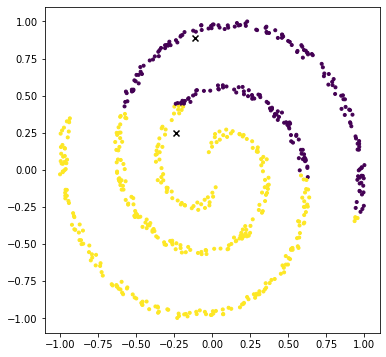

Epoch: 1099, Acc:0.62, Loss:0.6529912352561951
Epoch: 1199, Acc:0.63, Loss:0.6481084823608398
Epoch: 1299, Acc:0.63, Loss:0.6437079906463623
Epoch: 1399, Acc:0.62, Loss:0.639863133430481
Epoch: 1499, Acc:0.62, Loss:0.636505663394928
Epoch: 1599, Acc:0.62, Loss:0.6335471272468567
Epoch: 1699, Acc:0.63, Loss:0.6309086680412292
Epoch: 1799, Acc:0.63, Loss:0.6285215020179749
Epoch: 1899, Acc:0.63, Loss:0.6263342499732971
Epoch: 1999, Acc:0.63, Loss:0.6243059039115906


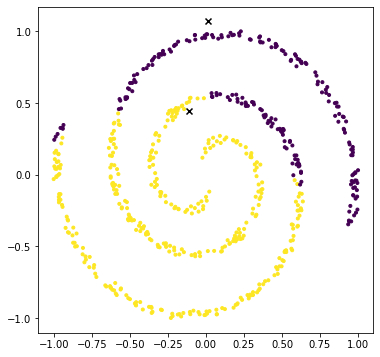

Epoch: 2099, Acc:0.63, Loss:0.6223957538604736
Epoch: 2199, Acc:0.63, Loss:0.6205687522888184
Epoch: 2299, Acc:0.63, Loss:0.618791937828064
Epoch: 2399, Acc:0.63, Loss:0.617031991481781
Epoch: 2499, Acc:0.64, Loss:0.6152525544166565
Epoch: 2599, Acc:0.64, Loss:0.6134192943572998
Epoch: 2699, Acc:0.64, Loss:0.611514151096344
Epoch: 2799, Acc:0.65, Loss:0.6095616221427917
Epoch: 2899, Acc:0.65, Loss:0.6076459884643555
Epoch: 2999, Acc:0.66, Loss:0.6057519912719727


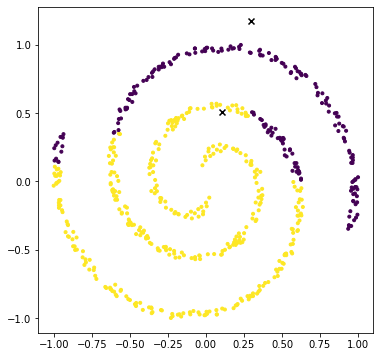

Epoch: 3099, Acc:0.67, Loss:0.6037979125976562
Epoch: 3199, Acc:0.68, Loss:0.6018373370170593
Epoch: 3299, Acc:0.69, Loss:0.5999783277511597
Epoch: 3399, Acc:0.69, Loss:0.5982598662376404
Epoch: 3499, Acc:0.70, Loss:0.5967183113098145
Epoch: 3599, Acc:0.70, Loss:0.5953287482261658
Epoch: 3699, Acc:0.70, Loss:0.5941439270973206
Epoch: 3799, Acc:0.70, Loss:0.5930556058883667
Epoch: 3899, Acc:0.70, Loss:0.5920283794403076
Epoch: 3999, Acc:0.70, Loss:0.5910516977310181


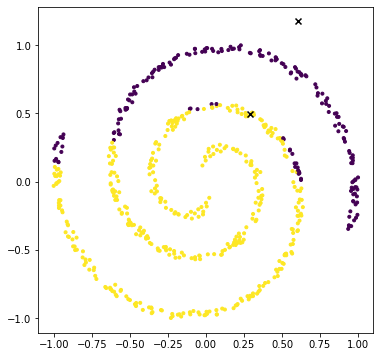

Epoch: 4099, Acc:0.70, Loss:0.590117335319519
Epoch: 4199, Acc:0.70, Loss:0.5892235636711121
Epoch: 4299, Acc:0.70, Loss:0.5883738994598389
Epoch: 4399, Acc:0.70, Loss:0.5875673294067383
Epoch: 4499, Acc:0.70, Loss:0.5868028402328491
Epoch: 4599, Acc:0.70, Loss:0.5860783457756042
Epoch: 4699, Acc:0.70, Loss:0.5853896737098694
Epoch: 4799, Acc:0.70, Loss:0.5847400426864624
Epoch: 4899, Acc:0.70, Loss:0.5841343998908997
Epoch: 4999, Acc:0.70, Loss:0.5835614204406738


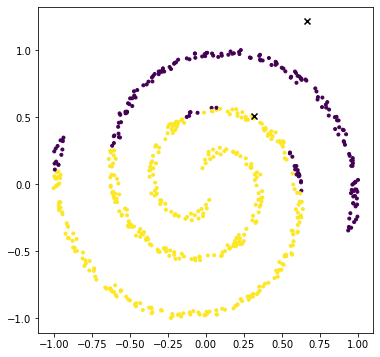

In [790]:
%matplotlib inline

for epoch in range(5000):
# for epoch in range(100):
    yout = model(xx)
    
#     yout.register_hook(lambda grad: grad/torch.norm(grad, dim=1, keepdim=True))
    
    loss = criterion(yout, yy)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
#     model.bias.data *= 0. ## Neglect the bias use

    if (epoch+1)%100 == 0:
        yout = model(xx)
        accuracy = (yout.max(dim=1)[1] == yy).type(torch.float).mean()                
        print(f'Epoch: {epoch}, Acc:{float(accuracy):.2f}, Loss:{float(loss)}')

    if (epoch+1)%1000 == 0:
        ax = plt.figure(figsize=(6,6)).add_subplot()
        out = yout.max(dim=1)[1].data.cpu().numpy()
        ax.scatter(x1, x2, c=out, marker= '.')
        ## plot centroids
        c = model.centers.data.cpu()
        ax.scatter(c[:,0], c[:,1], color='k', marker= 'x')
        plt.show()

In [791]:
num_points = 1000
X1 = np.linspace(-1.5, 1.5, num_points)*2
X2 = np.linspace(-1.5, 1.5, num_points)*2
X1, X2 = np.meshgrid(X1, X2)

XX = torch.Tensor(np.c_[X1.reshape(-1), X2.reshape(-1)]).to(device)
XX.shape

torch.Size([1000000, 2])

In [792]:
# YY = F.softmax(model(XX), dim=-1)
YY = model(XX)
YY = YY.reshape(num_points, num_points, -1)
YY.shape

torch.Size([1000, 1000, 3])

In [793]:
max_actv = model(model.centers.data).data.cpu()
max_actv = max_actv.diag().numpy()
max_actv

array([0.9984285, 0.676646 ], dtype=float32)

center: 0.9984285 max_grid: 0.99842834 True


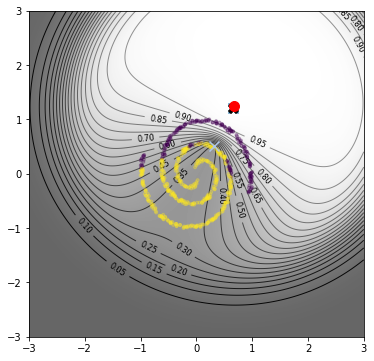

center: 0.676646 max_grid: 0.67664206 True


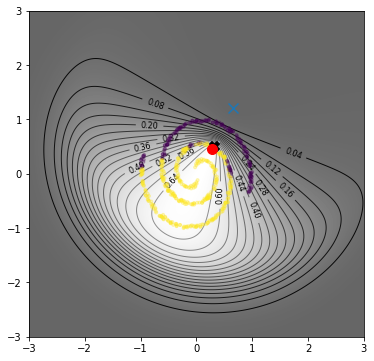

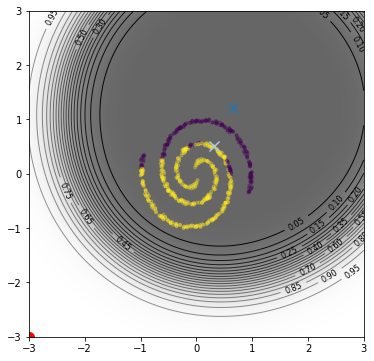

In [794]:
for idx in range(YY.shape[-1]):
    conf = YY[:,:,idx]
    conf = conf.data.cpu().numpy().reshape(X1.shape)
    
    ax = plt.figure(figsize=(6,6)).add_subplot()
    ax.scatter(x1, x2, c=out, marker= '.', alpha=0.3)

    ## plot centroids
    c = model.centers.data.cpu()
    for i in range(c.shape[0]):
        color = matplotlib.cm.tab20(i%20)
        ax.scatter(c[i,0], c[i,1], color=color, marker= 'x', s=100)
    
    try:
        ax.scatter(c[idx,0], c[idx,1], color="k", marker= 'X', s=100)
        print(f"center:",max_actv[idx],"max_grid:",conf.max(), max_actv[idx] >= conf.max())
    except:
        pass
    
    maxpt = XX[conf.argmax()]
    ax.scatter(maxpt[0], maxpt[1], color="r", marker= 'o', s=100)
    
    plt.imshow(conf, interpolation='nearest',
           extent=(X1.min(), X1.max(), X2.min(), X2.max()),
           alpha=0.6, cmap='gray',
           aspect='auto', origin='lower')
    
    LVLs = 20
#     LVLs = torch.linspace(0.0, 0.99, 20)
    cs = ax.contour(X1, X2, conf, levels=LVLs, linestyles="None", colors="k", linewidths=1, zorder=-2)
    ax.clabel(cs, cs.levels, inline=True, fontsize=8, fmt="%1.2f")
    
    plt.show()

In [758]:
# conf[0]

In [795]:
model.bias.data, model.scaler

(tensor([[ 2.4305, -0.4277, -2.1391]]), Parameter containing:
 tensor([[4.5636]], requires_grad=True))

In [504]:
# cs.levels

In [ ]:
"""
"""

### DTeSM Residual 

In [930]:
class DTeSM(DistanceTransform_Epsilon):
    
    def __init__(self, input_dim, output_dim, epsilon=1.0, itemp=10):
        super().__init__(input_dim, output_dim, bias=False, epsilon=epsilon)
        
        self.scale_shift = dtnn.ScaleShift(-1, scaler_init=itemp, shifter_init=0, scaler_const=True, shifter_const=True)
        self.softmax = nn.Softmax(dim=-1)
        self.temp_activ = None
        
    def forward(self, x):
        xo = super().forward(x)
        xo = self.scale_shift(xo)
        xo = self.softmax(xo)
        self.temp_activ = xo.data
#         return xo[:, :-1]
        return xo

In [931]:
class LocalResidual_DTeSM(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, epsilon=None, itemp=1.0):
        super().__init__()
        self.layer0 = DTeSM(input_dim, hidden_dim, epsilon, itemp)
        if epsilon is not None:
            hidden_dim += 1
        self.layer1 = nn.Linear(hidden_dim, input_dim)
        
    def forward(self, x):
        h = self.layer0(x)
        h = x + self.layer1(h)
        return h

In [932]:
model = LocalResidual_DTeSM(2, 5, epsilon=2.0, itemp=5.0)
model(xx).shape

torch.Size([600, 2])

In [933]:
model.layer0.temp_activ

tensor([[8.0991e-02, 1.8620e-01, 4.4103e-02, 1.3189e-03, 6.8721e-01, 1.8112e-04],
        [8.2357e-02, 1.7263e-01, 4.3252e-02, 1.2377e-03, 7.0033e-01, 1.8717e-04],
        [1.2844e-01, 4.9990e-02, 4.5107e-02, 6.5201e-04, 7.7572e-01, 8.5279e-05],
        ...,
        [6.6731e-02, 3.2380e-01, 3.8530e-02, 1.9693e-03, 5.6740e-01, 1.5765e-03],
        [3.4364e-01, 3.1097e-02, 7.9548e-02, 7.5687e-04, 5.4475e-01, 2.0352e-04],
        [8.3276e-02, 5.8724e-01, 2.0180e-01, 2.1921e-02, 1.0569e-01, 8.1463e-05]])

In [1003]:
model = nn.Sequential(
            LocalResidual_DTeSM(2, 10, epsilon=1.0, itemp=1.0),
            DT_epsilon_Classifier(2, 2, epsilon=1.0)
            )

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [1004]:
yout = model(xx)
yout.shape

torch.Size([600, 3])

In [1005]:
yy = yy.reshape(-1).type(torch.LongTensor)

In [1006]:
def criterion(output, target):
    return F.nll_loss(torch.log(output), target)

Epoch: 99, Acc:0.53, Loss:1.0173338651657104
Epoch: 199, Acc:0.54, Loss:0.9466764330863953
Epoch: 299, Acc:0.55, Loss:0.8958163261413574
Epoch: 399, Acc:0.55, Loss:0.8499099612236023
Epoch: 499, Acc:0.59, Loss:0.8050093650817871
Epoch: 599, Acc:0.60, Loss:0.7598626017570496
Epoch: 699, Acc:0.64, Loss:0.6866934299468994
Epoch: 799, Acc:0.67, Loss:0.6209105253219604
Epoch: 899, Acc:0.77, Loss:0.5598544478416443
Epoch: 999, Acc:0.84, Loss:0.5023793578147888


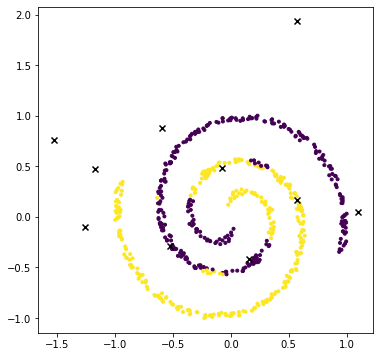

Epoch: 1099, Acc:0.86, Loss:0.45663467049598694
Epoch: 1199, Acc:0.88, Loss:0.42074111104011536
Epoch: 1299, Acc:0.88, Loss:0.38970646262168884
Epoch: 1399, Acc:0.90, Loss:0.3619363009929657
Epoch: 1499, Acc:0.91, Loss:0.33623695373535156
Epoch: 1599, Acc:0.92, Loss:0.3116552531719208
Epoch: 1699, Acc:0.93, Loss:0.28774258494377136
Epoch: 1799, Acc:0.94, Loss:0.26386529207229614
Epoch: 1899, Acc:0.95, Loss:0.24006077647209167
Epoch: 1999, Acc:0.96, Loss:0.21708427369594574


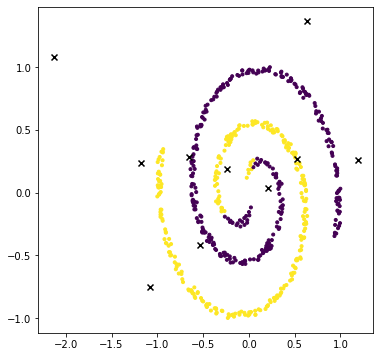

Epoch: 2099, Acc:0.96, Loss:0.19571608304977417
Epoch: 2199, Acc:0.98, Loss:0.17638494074344635
Epoch: 2299, Acc:0.98, Loss:0.15927423536777496
Epoch: 2399, Acc:0.98, Loss:0.14428569376468658
Epoch: 2499, Acc:0.99, Loss:0.13117630779743195
Epoch: 2599, Acc:0.99, Loss:0.11969739198684692
Epoch: 2699, Acc:0.99, Loss:0.10961803793907166
Epoch: 2799, Acc:1.00, Loss:0.10073957592248917
Epoch: 2899, Acc:1.00, Loss:0.09287887066602707
Epoch: 2999, Acc:1.00, Loss:0.08587680757045746


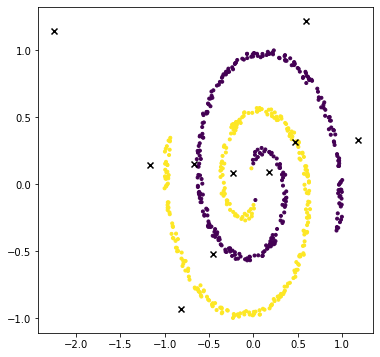

Epoch: 3099, Acc:1.00, Loss:0.07962414622306824
Epoch: 3199, Acc:1.00, Loss:0.07401914894580841
Epoch: 3299, Acc:1.00, Loss:0.06897559762001038
Epoch: 3399, Acc:1.00, Loss:0.06441967189311981
Epoch: 3499, Acc:1.00, Loss:0.06028740480542183
Epoch: 3599, Acc:1.00, Loss:0.05652423948049545
Epoch: 3699, Acc:1.00, Loss:0.05308554694056511
Epoch: 3799, Acc:1.00, Loss:0.049933429807424545
Epoch: 3899, Acc:1.00, Loss:0.047035034745931625
Epoch: 3999, Acc:1.00, Loss:0.04436251521110535


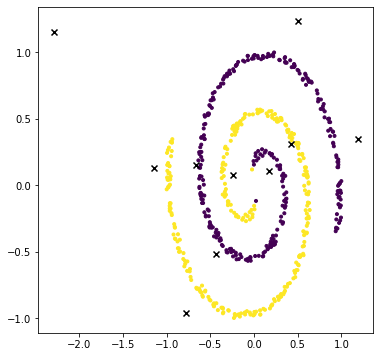

Epoch: 4099, Acc:1.00, Loss:0.04189010336995125
Epoch: 4199, Acc:1.00, Loss:0.03960198909044266
Epoch: 4299, Acc:1.00, Loss:0.03746900334954262
Epoch: 4399, Acc:1.00, Loss:0.03548596426844597
Epoch: 4499, Acc:1.00, Loss:0.03363519534468651
Epoch: 4599, Acc:1.00, Loss:0.03190603107213974
Epoch: 4699, Acc:1.00, Loss:0.030284417793154716
Epoch: 4799, Acc:1.00, Loss:0.02876466140151024
Epoch: 4899, Acc:1.00, Loss:0.02733401022851467
Epoch: 4999, Acc:1.00, Loss:0.02598698064684868


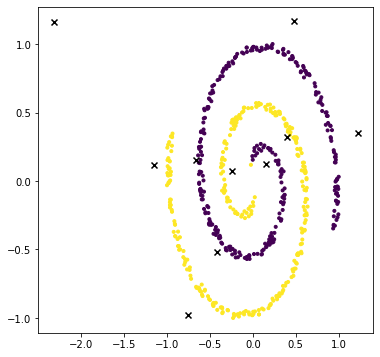

In [1007]:
%matplotlib inline

for epoch in range(5000):
    yout = model(xx)
    
    loss = criterion(yout, yy)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
#     model.bias.data *= 0. ## Neglect the bias use
#     model[0].layer0.scaler.data = model[0].layer0.scaler.data*0+1.

    if (epoch+1)%100 == 0:
        yout = model(xx)
        accuracy = (yout.max(dim=1)[1] == yy).type(torch.float).mean()                
        print(f'Epoch: {epoch}, Acc:{float(accuracy):.2f}, Loss:{float(loss)}')

    if (epoch+1)%1000 == 0:
        ax = plt.figure(figsize=(6,6)).add_subplot()
        out = yout.max(dim=1)[1].data.cpu().numpy()
        ax.scatter(x1, x2, c=out, marker= '.')
        ## plot centroids
        c = model[0].layer0.centers.data.cpu()
        ax.scatter(c[:,0], c[:,1], color='k', marker= 'x')
        plt.show()

In [1008]:
model[0]

LocalResidual_DTeSM(
  (layer0): DTeSM(
    (scale_shift): ScaleShift()
    (softmax): Softmax(dim=-1)
  )
  (layer1): Linear(in_features=11, out_features=2, bias=True)
)

In [1009]:
h1 = model[0](xx)
yout = model[1](h1)
out = yout.max(dim=1)[1].data.cpu().numpy()
## centroids and shift
c = model[0].layer0.centers.data.cpu()
d = model[0].layer1.weight.data.cpu().t() #+ net.net[-1].bias.data.cpu()

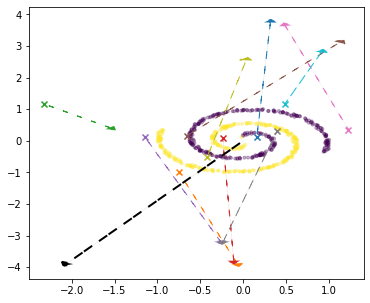

In [1012]:
ax = plt.figure(figsize=(6,5)).add_subplot()
ax.scatter(x1, x2, c=out, marker= '.', alpha=0.3)

for i in range(c.shape[0]):
    color = matplotlib.cm.tab10(i%20)
    ax.arrow(c[i,0], c[i,1], d[i,0], d[i,1], head_width=0.15, head_length=0.1, fc=color, ec=color, linestyle=(0, (5, 10)))
    ax.scatter(c[i,0], c[i,1], color=color, marker= 'x')

ax.arrow(0, 0, d[len(c),0], d[len(c),1], head_width=0.15, head_length=0.1, fc="k", ec="k", linestyle=(0, (5, 10)), linewidth=2.0)
    
# plt.xlim(-1.9, 1.8)
# plt.ylim(-2.2, 1.8)
plt.show()

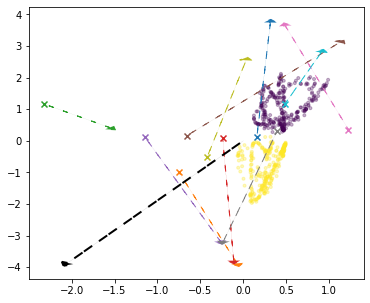

In [1013]:
ax = plt.figure(figsize=(6,5)).add_subplot()
ax.scatter(h1.data[:,0], h1.data[:,1], c=out, marker= '.', alpha=0.3)

for i in range(c.shape[0]):
    color = matplotlib.cm.tab10(i%20)
    ax.arrow(c[i,0], c[i,1], d[i,0], d[i,1], head_width=0.15, head_length=0.1, fc=color, ec=color, linestyle=(0, (5, 10)))
    ax.scatter(c[i,0], c[i,1], color=color, marker= 'x')
    
color = "k"
ax.arrow(0, 0, d[len(c),0], d[len(c),1], head_width=0.15, head_length=0.1, fc="k", ec="k", linestyle=(0, (5, 10)), linewidth=2.0)

    
# plt.xlim(-1.9, 1.8)
# plt.ylim(-2.2, 1.8)
plt.show()

### Visualize residual layer

In [1014]:
model[0](XX)
YY = model[0].layer0.temp_activ
YY = YY.reshape(num_points, num_points, -1)
YY.shape

torch.Size([1000, 1000, 11])

In [1015]:
# dir(model[0].layer0)

In [1016]:
max_actv = model[0].layer0(model[0].layer0.centers.data).data.cpu()
max_actv = max_actv.diag().numpy()
max_actv

array([0.7470712 , 0.94581985, 0.9951702 , 0.773775  , 0.9141846 ,
       0.8220885 , 0.9784371 , 0.80227834, 0.88865435, 0.97880584],
      dtype=float32)

center: 0.7470712 max_grid: 0.7446826 True


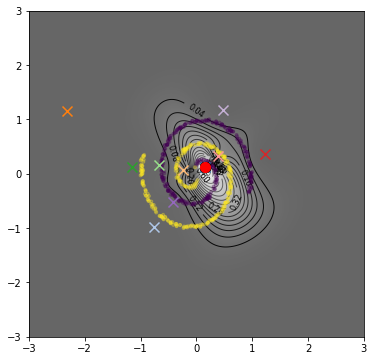

center: 0.94581985 max_grid: 0.94577587 True


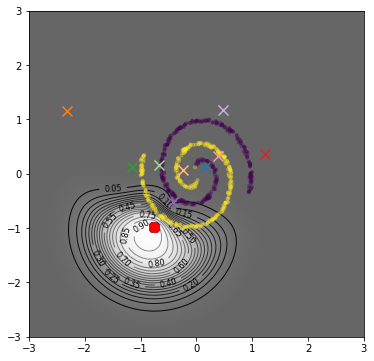

center: 0.9951702 max_grid: 0.9951363 True


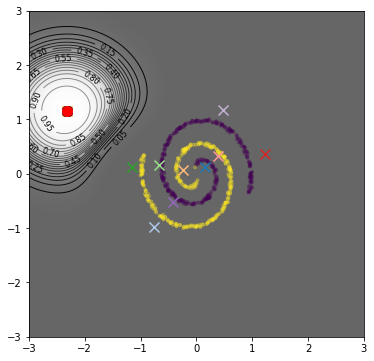

center: 0.773775 max_grid: 0.77113336 True


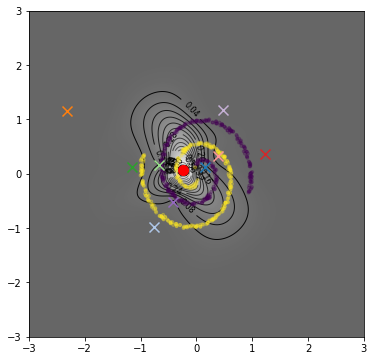

center: 0.9141846 max_grid: 0.91391367 True


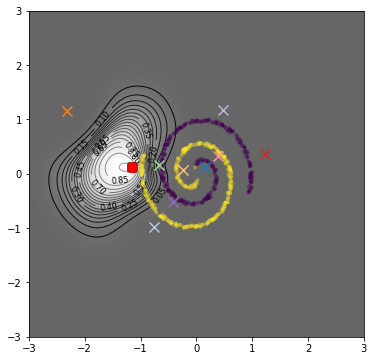

center: 0.8220885 max_grid: 0.82010823 True


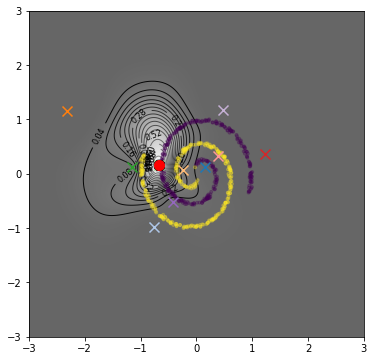

center: 0.9784371 max_grid: 0.9782689 True


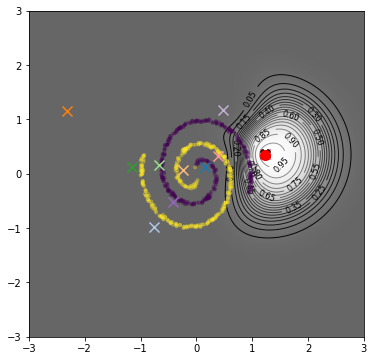

center: 0.80227834 max_grid: 0.8016604 True


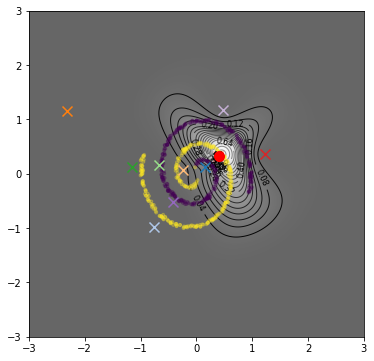

center: 0.88865435 max_grid: 0.8868446 True


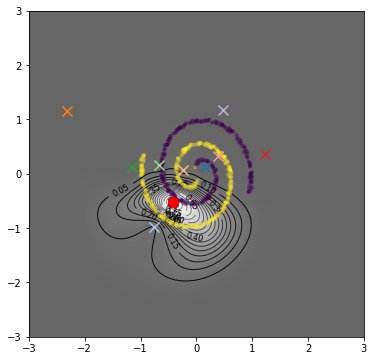

center: 0.97880584 max_grid: 0.97870195 True


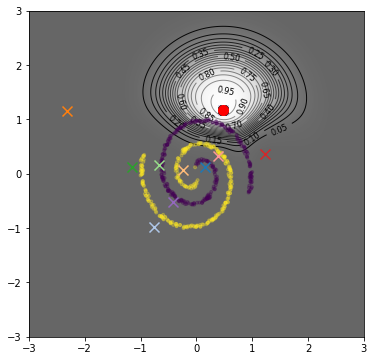

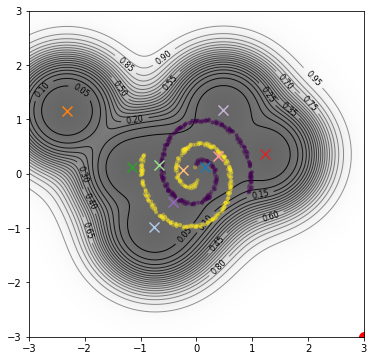

In [1017]:
for idx in range(YY.shape[-1]):
    conf = YY[:,:,idx]
    conf = conf.data.cpu().numpy().reshape(X1.shape)
    
    ax = plt.figure(figsize=(6,6)).add_subplot()
    ax.scatter(x1, x2, c=out, marker= '.', alpha=0.3)

    ## plot centroids
    for i in range(c.shape[0]):
        color = matplotlib.cm.tab20(i%20)
        ax.scatter(c[i,0], c[i,1], color=color, marker= 'x', s=100)
    
    try:
        ax.scatter(c[idx,0], c[idx,1], color="k", marker= 'X', s=100)
        print(f"center:",max_actv[idx],"max_grid:",conf.max(), max_actv[idx] >= conf.max())
    except:
        pass
    
    maxpt = XX[conf.argmax()]
    ax.scatter(maxpt[0], maxpt[1], color="r", marker= 'o', s=100)
    
    plt.imshow(conf, interpolation='nearest',
           extent=(X1.min(), X1.max(), X2.min(), X2.max()),
           alpha=0.6, cmap='gray',
           aspect='auto', origin='lower')
    
    LVLs = 20
#     LVLs = torch.linspace(0.0, 0.99, 20)
    cs = ax.contour(X1, X2, conf, levels=LVLs, linestyles="None", colors="k", linewidths=1, zorder=-2)
    ax.clabel(cs, cs.levels, inline=True, fontsize=8, fmt="%1.2f")
    
    plt.show()

In [1002]:
model[0].layer0.scaler, model[0].layer0.bias

(Parameter containing:
 tensor([[4.6566]], requires_grad=True), None)

### Visualize Classification Layer

In [998]:
# YY = F.softmax(model(XX), dim=-1)
YY = model[1](XX)
YY = YY.reshape(num_points, num_points, -1)
YY.shape

torch.Size([1000, 1000, 3])

In [999]:
max_actv = model[1](model[1].centers.data).data.cpu()
max_actv = max_actv.diag().numpy()
max_actv

array([0.99962664, 0.9995419 ], dtype=float32)

In [1000]:
c = model[1].centers.data.cpu()
h1 = model[0](xx)

center: 0.99962664 max_grid: 0.9996239 True


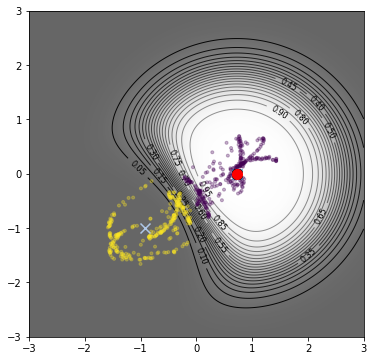

center: 0.9995419 max_grid: 0.9995372 True


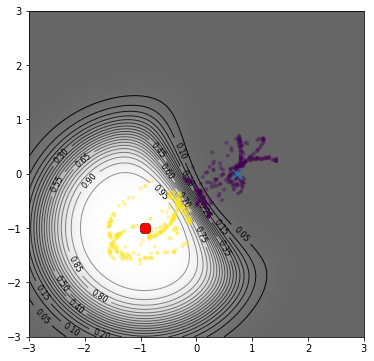

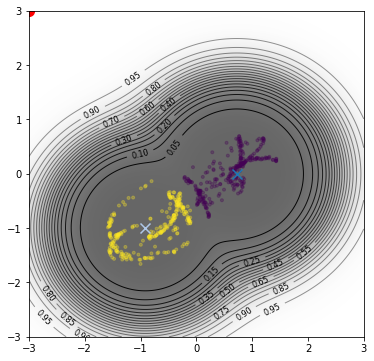

In [1001]:
for idx in range(YY.shape[-1]):
    conf = YY[:,:,idx]
    conf = conf.data.cpu().numpy().reshape(X1.shape)
    
    ax = plt.figure(figsize=(6,6)).add_subplot()
    ax.scatter(h1.data[:,0], h1.data[:,1], c=out, marker= '.', alpha=0.3)

    ## plot centroids
    for i in range(c.shape[0]):
        color = matplotlib.cm.tab20(i%20)
        ax.scatter(c[i,0], c[i,1], color=color, marker= 'x', s=100)
    
    try:
        ax.scatter(c[idx,0], c[idx,1], color="k", marker= 'X', s=100)
        print(f"center:",max_actv[idx],"max_grid:",conf.max(), max_actv[idx] >= conf.max())
    except:
        pass
    
    maxpt = XX[conf.argmax()]
    ax.scatter(maxpt[0], maxpt[1], color="r", marker= 'o', s=100)
    
    plt.imshow(conf, interpolation='nearest',
           extent=(X1.min(), X1.max(), X2.min(), X2.max()),
           alpha=0.6, cmap='gray',
           aspect='auto', origin='lower')
    
    LVLs = 20
#     LVLs = torch.linspace(0.0, 0.99, 20)
    cs = ax.contour(X1, X2, conf, levels=LVLs, linestyles="None", colors="k", linewidths=1, zorder=-2)
    ax.clabel(cs, cs.levels, inline=True, fontsize=8, fmt="%1.2f")
    
    plt.show()

## Overfit Residual Classifier with manual data based initialization

In [23]:
asdasdasdsd

NameError: name 'asdasdasdsd' is not defined